排除掉所有的已知源区域。
使用healpy作为全天分bin的方法。
下面这段是演示healpy。

In [1]:
# 矩阵计算
import numpy as np

# root文件读取
import uproot

# 球面分bin
import healpy as hp

# 表格
import pandas as pd

# 单位与坐标变换
from astropy import units as u
from astropy.coordinates import SkyCoord

In [9]:
NSIDE = 2**2
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 4 is 1.5e+01 deg


In [10]:
NPIX = hp.nside2npix(NSIDE)
print(f"全天分bin数：{NPIX}")

全天分bin数：192


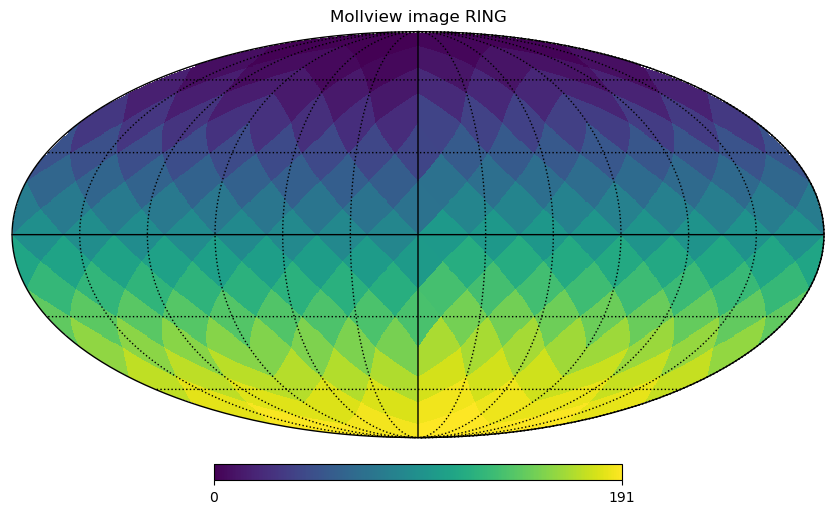

In [11]:
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

为了运行速度，使用$NSIDE=2^9$

In [5]:
NSIDE = 2**9
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 512 is 0.11 deg


In [6]:
# 计算每一个格子的Ra与Dec
Ra, Dec = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat=True)

# 将赤道坐标系的每一个点转到银道坐标系下，
# 并找出所有银纬绝对值小于5度的点，在挑选宇宙线时排除
icrscoordiantes = SkyCoord(
    ra=Ra * u.deg,
    dec=Dec * u.deg,
    frame="icrs",
)
galactic = icrscoordiantes.galactic
galactic_b_5 = np.where(np.abs(galactic.b.degree) < 5)

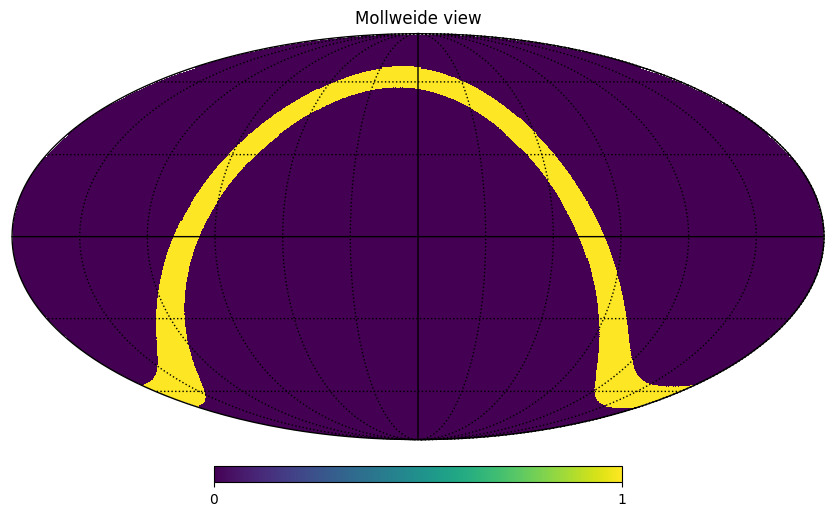

In [7]:
# 排除掉的银道面的点如图所示
mask_map = np.zeros(NPIX)
mask_map[galactic_b_5] = 1
hp.mollview(mask_map)
hp.graticule()

In [8]:
# 读取TeVcat上已知的源
TeVdata = pd.read_table("./TeVcat.log")
Ra_TeVcat = TeVdata["Ra"].to_numpy()
Dec_TeVcat = TeVdata["Dec"].to_numpy()
for i in range(len(Ra_TeVcat)):
    Ra_TeVcat_tmp = Ra_TeVcat[i].split()
    Dec_TeVcat_tmp = Dec_TeVcat[i].split()
    Ra_TeVcat[i] = (
        float(Ra_TeVcat_tmp[0]) / 24
        + float(Ra_TeVcat_tmp[1]) / 24 / 60
        + float(Ra_TeVcat_tmp[2]) / 24 / 60 / 60
    ) * 360
    Dec_TeVcat[i] = float(Dec_TeVcat_tmp[0])
    delta_Dec_TeVcat = (
        float(Dec_TeVcat_tmp[1]) / 60 + float(Dec_TeVcat_tmp[2]) / 60 / 60
    )
    Dec_TeVcat[i] += (-1) ** (Dec_TeVcat[i] < 0) * delta_Dec_TeVcat

Ra_TeVcat = Ra_TeVcat.astype(np.float32)
Dec_TeVcat = Dec_TeVcat.astype(np.float32)

In [9]:
TeVdata

,Name,Ra,Dec,Type
0,GRB 180720B,0.531667,-2.935,GRB
1,CTA 1,1.608333,72.983611,PWN
2,SHBL J001355.9-185406,3.466667,-18.891389,HBL
3,Tycho,6.34,64.13,Shell
4,KUV 00311-1938,8.4,-19.35,HBL
...,...,...,...,...
247,B3 2247+381,342.5275,38.432778,HBL
248,Cassiopeia A,350.8075,58.807222,Shell
249,1ES 2322-409,351.2,-40.66,HBL
250,1ES 2344+514,356.766667,51.713611,HBL


In [10]:
# 去除掉每个已知源周围1度的数据。
for Ra_tmp, Dec_tmp in zip(Ra_TeVcat, Dec_TeVcat):
    mask_map[
        hp.query_disc(NSIDE, hp.ang2vec(Ra_tmp, Dec_tmp, lonlat=True), np.radians(1))
    ] = 1
# geminga 去除3度
mask_map[hp.query_disc(NSIDE, hp.ang2vec(98.5, 17.8, lonlat=True), np.radians(3))] = 1

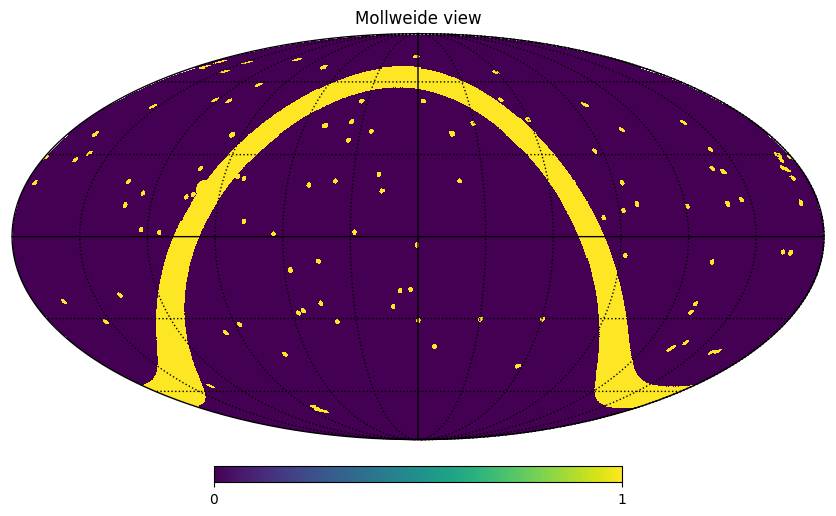

In [11]:
# 所有去除的点如图所示。
hp.mollview(mask_map)
hp.graticule()

In [12]:
# 保存这个数据
np.save("./knownsource.npy",mask_map)